In [200]:
import wave
import numpy as np
import matplotlib.pyplot as plt

In [247]:
wav_file = wave.open('../live_output/2024-07-05_18-57_noaa_apt_137.1 MHz/LO_demodulated_2.wav', 'rb') #read binary - otwiera plik w trybie binarnym

In [249]:
params = wav_file.getparams()
print(params)

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=1482159, comptype='NONE', compname='not compressed')


In [251]:
n_channels = wav_file.getnchannels()
sample_width = wav_file.getsampwidth()
frame_rate = wav_file.getframerate()
n_frames = wav_file.getnframes()
compression_type = wav_file.getcomptype()
compression_name = wav_file.getcompname()

print("Liczba kanałów: ", n_channels)
print("Szerokość próbki w B: ",sample_width)
print("Częstotliwość próbkowania w Hz: ",frame_rate)
print("Liczba ramek: ",n_frames)
print("Typ kompresji: ",compression_type)
print("Nazwa kompresji: ",compression_name)

Liczba kanałów:  1
Szerokość próbki w B:  2
Częstotliwość próbkowania w Hz:  11025
Liczba ramek:  1482159
Typ kompresji:  NONE
Nazwa kompresji:  not compressed


In [253]:
# szerokość próbki w bitach; sample_width x 1 B = 16 b
# czas trwania przelotu w s; n_frames/frame_rate 
print("Czas przelotu w min: ", n_frames/frame_rate/60)
duration_t=n_frames/frame_rate 

Czas przelotu w min:  2.2406031746031747


In [255]:
data_type = np.int16

In [257]:
duration = 0.5  # Czas trwania w sekundach
frames = int(frame_rate * duration)
raw_data = wav_file.readframes(frames) #frames or n_frames
wav_file.close()


In [259]:
print(data_type)

#print(raw_data[:10]) # b - bytes, w kodzie 16, jedna liczba to 2 B (little endian - mniej znaczący B jest 1, bardziej 2)
#Tablica liczb całkowitych z ciągu bajtów
int_data = np.frombuffer(raw_data, data_type)
print(int_data)
# Aby nie utracić danych zmiennoprzecinkowych
float_data = int_data.astype(np.float32)
print(float_data)

<class 'numpy.int16'>
[-3586 12892 19613 ... 15328 16978 -6512]
[-3586. 12892. 19613. ... 15328. 16978. -6512.]


In [261]:
print(raw_data[:22])

b"\xfe\xf1\\2\x9dL\x10\xf3\xf8\xc0F\xfd\x11NC'\x98\xe6]\xfb\x8a "


In [263]:
#zakres wartości
print(-2**15)
print((2**15)-1)
#Normalizacja sygnału do zakresu od -1 do 1
max_war = 2**(16-1)
float_data /= max_war # każdy element przez max, aby unormować
print(float_data)

-32768
32767
[-0.10943604  0.39343262  0.59854126 ...  0.46777344  0.51812744
 -0.19873047]


In [265]:
N = len(float_data)
t = np.linspace(0,duration, N)

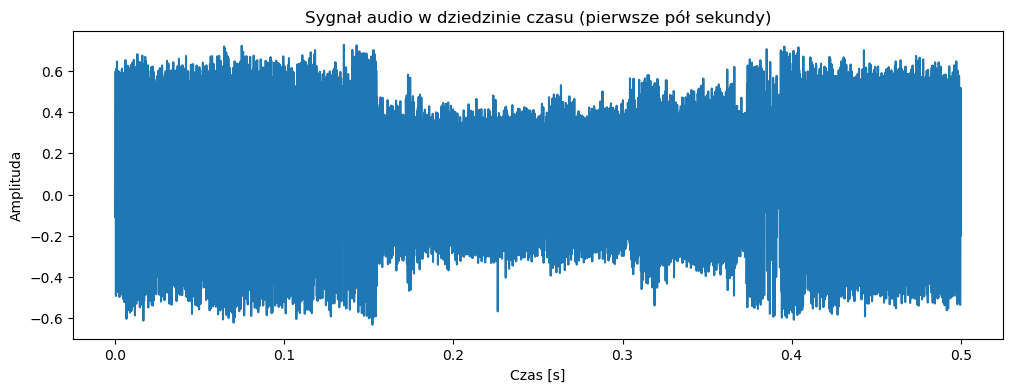

In [267]:
plt.figure(figsize=(12, 4))
plt.plot(t, float_data)
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Sygnał audio w dziedzinie czasu (pierwsze pół sekundy)')
plt.show()

In [269]:
from scipy.signal import hilbert


analytic_signal = hilbert(float_data)

I = np.real(analytic_signal)
Q = np.imag(analytic_signal)

envelope = np.sqrt(I**2+Q**2)

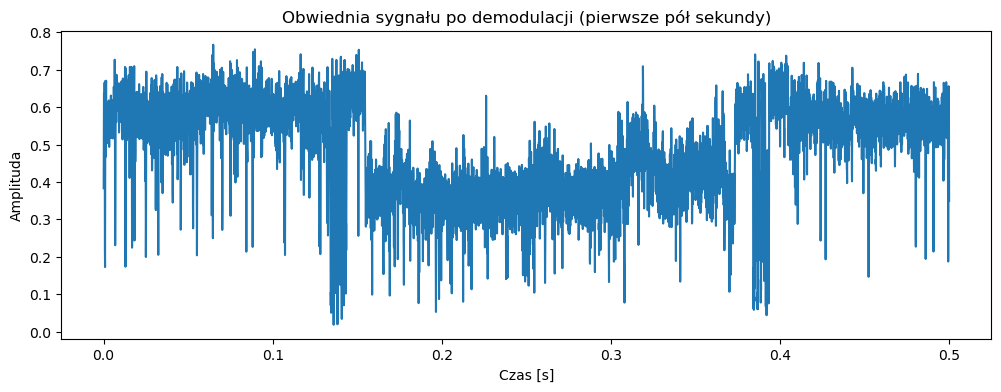

In [270]:
N = len(envelope)
t = np.linspace(0,duration, N)
plt.figure(figsize=(12, 4))
plt.plot(t, envelope)
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Obwiednia sygnału po demodulacji (pierwsze pół sekundy)')
plt.show()

In [273]:
freq_nyquista = frame_rate/2.0
cutoff = 2080
transition = 200
print(freq_nyquista)

5512.5


In [275]:
#normalizacja do freq_nyquista # max częstotliwość w której można zaprezentować sygnał
cutoff_norm = cutoff/freq_nyquista
transition_norm = transition/freq_nyquista

In [277]:
#przybliżenie Harrisa, do obliczenia współczynników filtra
Hamming_stop_att = 53
Blackamn_stop_att = 74
num_taps = 74*frame_rate/(22*transition)
print(num_taps)
num_taps = int(num_taps)

185.42045454545453


In [278]:
from scipy.signal import firwin

fir = firwin(
    numtaps = num_taps,
    cutoff = cutoff_norm,
    window = 'blackman',
    pass_zero = 'lowpass',
    scale=False
)

In [281]:
from scipy.signal import lfilter
envelope_filtered = lfilter(fir, 1.0, envelope)

In [283]:
delay = (num_taps - 1) // 2
corrected_envelope= envelope_filtered[delay:] # usuwam pierwsze próbki sygnału, które są opźnione przez wprowadzenie filtra
t_corrected = np.linspace(0, len(corrected_envelope) / frame_rate, num=len(corrected_envelope))


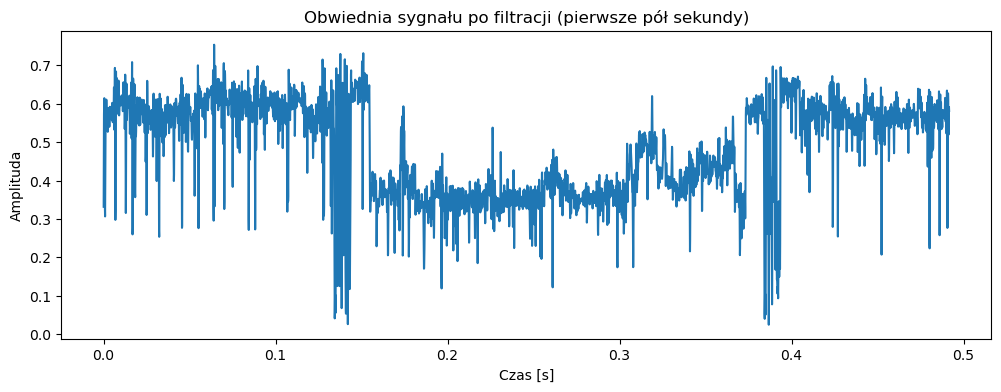

In [285]:
plt.figure(figsize=(12, 4))
plt.plot(t_corrected, corrected_envelope)
plt.title('Obwiednia sygnału po filtracji (pierwsze pół sekundy)')
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.show()

In [242]:
# Nie napisywać całych plików kawałkiem

In [244]:
#nie nadpisać pliku
#np.save('AM_demodulated_LO69_signal.npy', corrected_envelope)
#np.save('t_LO69_signal.npy', t_corrected)

In [38]:
#zmienna lokalna w czasie